# Titanic challenge

**Goal**: Use machine learning to predict survival of Titanic passengers based on their age, sex, passenger class, and more.

Contents of this notebook:
- [Import libraries](#Import-libraries)
- [Exploratory data analysis](#Exploratory-data-analysis)
    - [Load data and look at structure](#Load-data-and-look-at-structure)
    - [Visualize relationships between variables and survival rate](#Visualize-relationships-between-variables)
        - [Sex](#Sex)
        - [Age](#Age)
        - [Passenger class](#Passenger-class)
        - [Title](#Title)
- [Data cleaning/preprocessing](#Data-cleaning/preprocessing)
    - [Convert categorical variables to dummy variable representation](#Convert-categorical-variables-to-dummy-variable-representation)
        - [Pclass](#Pclass)
        - [Sex](#Sex)
    - [Impute age](#Impute-age)
    - [Min-max scale continuous variables](#Min-max-scale-continuous-variables)
- [Create model](#Create-model)

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
%matplotlib inline

# Exploratory data analysis

## Load data and look at structure

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Look at summary of quantitative variables
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Initial thoughts:
- At first glance/intuition, important variables for predicting survival might be:
    * Sex ("Women and children first"?)
    * Age (see above)
    * Pclass (wealthier people may have been more likely to get on a life boat)
    * Fare (possibly another way to view wealth)
    * Parch: # of parents/children aboard (maybe parents of children were more likely to be saved)
    * SibSp: # of siblings/spouses aboard (large families more likely to survive (or less?)?)
- Probably not as important:
    * Cabin
    * Embarked
    * Ticket
- There are a lot of missing entries for age. I'll probably want to impute some values, but not yet sure how (is age related to sex, class, etc.?).

## Visualize relationships between variables

First, a heatmap showing correlations between all numerical variables.

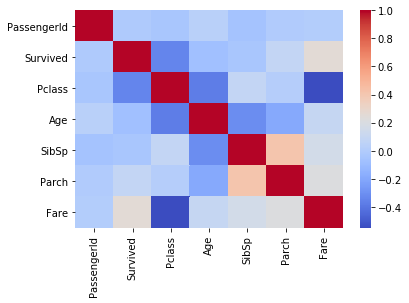

In [5]:
sns.heatmap(train_data.corr(), cmap='coolwarm')
plt.show()

Now, I'll look at the relationships between the variables that I predict will be most important for predicting survival: sex, age, and passenger class.

Since I'll be plotting a lot of survival rates, I should have functions to do that.

In [6]:
def get_survival_rate(df, group):
    """ Get survival rate by groups
            Input:
                df: dataframe
                group: string or list of strings to group data by
            Output: series of survival rates by groups
    """
    return df.groupby(group)['Survived'].mean()

def plot_survival_groupby(df, x, hue=None, figsize=(8,5)):
    """ Plot survival rate by groups
            Input:
                df: dataframe
                x: x-axis variable of barplot (e.g., 'Pclass')
                hue: variable to color plot by (e.g., 'Sex')
            Output: figure of survival rates by groups
    """
    # If hue not specified, only group data by x
    if hue is None:
        df2 = df.groupby(x)['Survived'].mean()
        title_addon = '' # Don't list hue in figure title
    else:
        df2 = df.groupby([x, hue])['Survived'].mean()
        title_addon = f' and {hue}' # List hue in figure title
    
    # Convert groupby series to dataframe for plotting
    df2 = df2.reset_index()
    
    # Create figure
    plt.figure(figsize = figsize)
    # Make plot, add labels, etc.
    sns.barplot(x = x, y = 'Survived', data = df2, hue = hue)
    plt.xlabel(x)
    plt.ylabel('Survival probability')
    plt.ylim((0,1.0))
    plt.title(f'Probability of survival by {x}{title_addon}')
    plt.show()

### Sex

First, let's look at the difference in survival between men and women

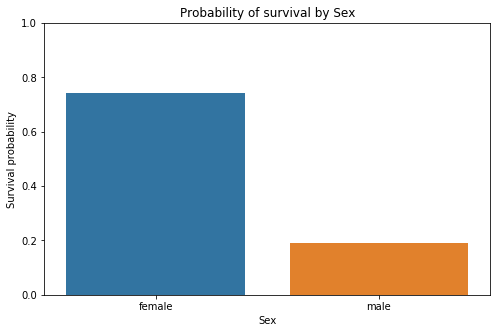

In [7]:
plot_survival_groupby(train_data, 'Sex')

Unsurprisingly, women were much more likely to survive than men.

### Age

Is there any effect of age on survival rate?

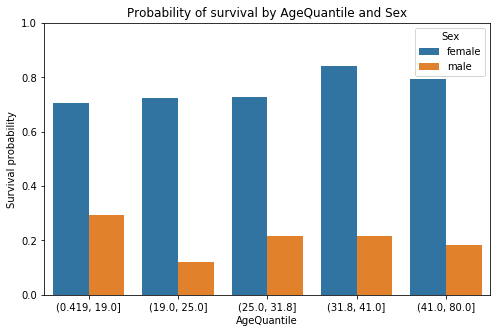

In [8]:
# Compute age quantiles
train_data['AgeQuantile'] = pd.qcut(train_data['Age'], q=5)
plot_survival_groupby(train_data, 'AgeQuantile', 'Sex')

It looks like young boys are more likely to survive than the rest of men. But let's make smaller age groups to see how specific this age effect is.

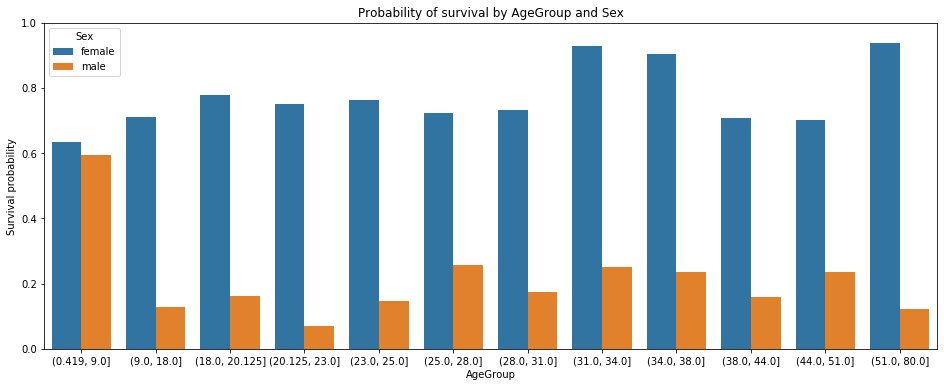

In [9]:
# Compute narrower age groups
train_data['AgeGroup'] = pd.qcut(train_data['Age'], q=12)
plot_survival_groupby(train_data, 'AgeGroup', 'Sex', figsize=(16,6))

There isn't a systematic effect of age on survival rates across sexes, but boys 9 and younger were the most likely to survive of boys and men. Let's create a column flagging whether a passenger was a boy 9 and under.

In [10]:
train_data['YoungBoy'] = ((train_data['Age']<9) & (train_data['Sex']=='male')).astype(int)
test_data['YoungBoy'] = ((test_data['Age']<9) & (test_data['Sex']=='male')).astype(int)

### Passenger class

What is the effect of passenger class on survival?

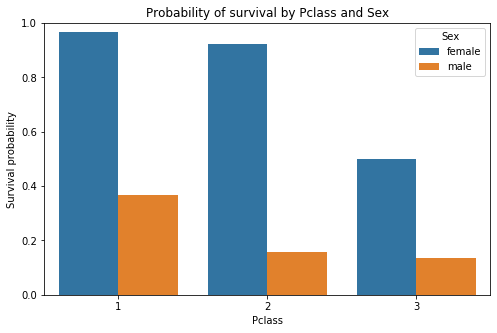

In [11]:
plot_survival_groupby(train_data, 'Pclass', 'Sex')

From this plot it is clear that:
- For both men and women, first-class passengers were most likely to survive and third-class passengers were least likely to survive.
- For women, there is little difference between classes 1 and 2, and for men, there is little difference between classes 2 and 3. This nonlinearity suggests that classes should be treated as categorical rather than continuous.

In [12]:
# Define upper-class woman as a woman in first or second class
upper_class_woman = (train_data['Sex'] == 'female') & ((train_data['Pclass']==1) | (train_data['Pclass']==2))
train_data['UpperClassWoman'] = upper_class_woman.astype(int)
# Define lower-class man as a man in second or third class
lower_class_man = (train_data['Sex'] == 'male') & ((train_data['Pclass']==2) | (train_data['Pclass']==3))
train_data['LowerClassMan'] = lower_class_man.astype(int)

# Apply same changes to test data
upper_class_woman = (test_data['Sex'] == 'female') & ((test_data['Pclass']==1) | (test_data['Pclass']==2))
test_data['UpperClassWoman'] = upper_class_woman.astype(int)
lower_class_man = (test_data['Sex'] == 'male') & ((test_data['Pclass']==2) | (test_data['Pclass']==3))
test_data['LowerClassMan'] = lower_class_man.astype(int)

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeQuantile,AgeGroup,YoungBoy,UpperClassWoman,LowerClassMan
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(19.0, 25.0]","(20.125, 23.0]",0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(31.8, 41.0]","(34.0, 38.0]",0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(25.0, 31.8]","(25.0, 28.0]",0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(31.8, 41.0]","(34.0, 38.0]",0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(31.8, 41.0]","(34.0, 38.0]",0,0,1


### Title

In [13]:
def extract_titles(df):
    """ Extract passenger titles
        Starting format: LastName, Title. FirstName MiddleName (OptionalOtherName)
            Input: dataframe with column 'Name'
            Output: list of titles
    """
    # Split last name from rest of string
    name_split = df['Name'].str.split(', ').to_list()
    # Extract string with title
    name = [x[1] for x in name_split]
    # Separate title from FirstName MiddleName
    title = [x.split('.')[0] for x in name]
    return title

def replace_uncommon_titles(df):
    """ Replace uncommon titles with "Other"
            Input: dataframe with column 'Title'
            Output: dataframe with updated 'Title' column
    """
    df.loc[~df['Title'].isin(['Mr', 'Mrs', 'Miss', 'Master']), 'Title'] = 'Other'
    return df

In [14]:
# Extract passenger titles
train_data['Title'] = extract_titles(train_data)
test_data['Title'] = extract_titles(test_data)

# View data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeQuantile,AgeGroup,YoungBoy,UpperClassWoman,LowerClassMan,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(19.0, 25.0]","(20.125, 23.0]",0,0,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(31.8, 41.0]","(34.0, 38.0]",0,1,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(25.0, 31.8]","(25.0, 28.0]",0,0,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(31.8, 41.0]","(34.0, 38.0]",0,1,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(31.8, 41.0]","(34.0, 38.0]",0,0,1,Mr


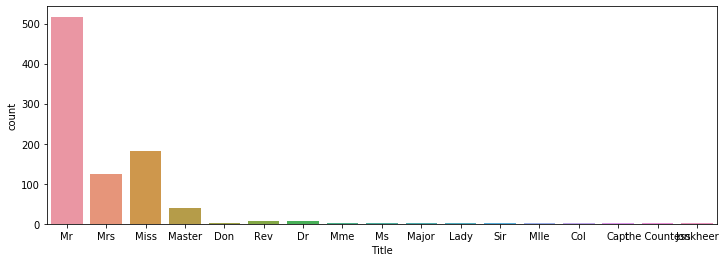

In [15]:
plt.figure(figsize = (12, 4))
sns.countplot(x = 'Title', data = train_data)
plt.show()

It's impossible to see those small numbers... let's make a table of value counts.

In [16]:
train_data['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Lady              1
Jonkheer          1
Capt              1
Sir               1
Mme               1
Don               1
Ms                1
the Countess      1
Name: Title, dtype: int64

Let's group all the uncommon titles into one category.

In [17]:
train_data = replace_uncommon_titles(train_data)
test_data = replace_uncommon_titles(test_data)

# View new counts of each title
train_data['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: Title, dtype: int64

Do titles have any relationship with survival probability?

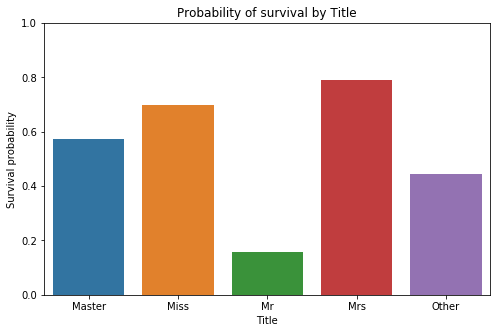

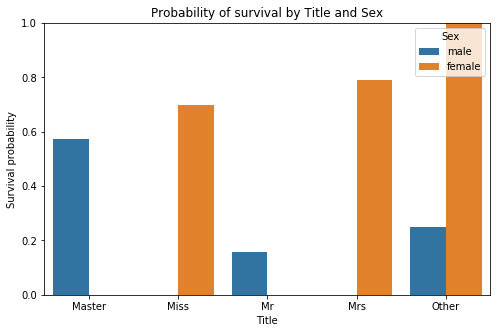

In [18]:
plot_survival_groupby(train_data, 'Title')
plot_survival_groupby(train_data, 'Title', 'Sex')

Married women (Mrs.) have a slightly higher survival probability than unmarried women/girls (Miss.), and people in the "other" category seem have higher survival rates than Mr./Mrs./Miss. for respective sex. Master has a relatively high survival probability, likely due to the young age implied by the title.

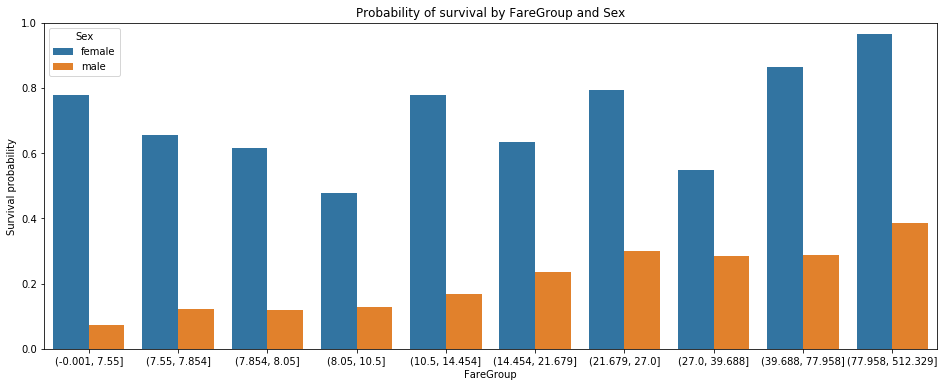

In [19]:
train_data['FareGroup'] = pd.qcut(train_data['Fare'],10)
plot_survival_groupby(train_data, 'FareGroup', 'Sex', figsize=(16,6))

Among men, there is a relatively systematic increase in survival probability for higher fares. There is no such relationship among women.

Important features for predicting survival:
- Women
- Passenger class: women in classes 1-2 more likely to survive, men in classes 2-3 less likely to survive
- Boys 7 and under
- People with "Other" titles

# Data cleaning/preprocessing

## Convert categorical variables to dummy variable representation

### Pclass

In [20]:
# Add passenger class as dummy variables to dataframe
pclass_onehot = pd.get_dummies(train_data['Pclass'])
pclass_onehot.columns = ['Pclass1', 'Pclass2', 'Pclass3']
train_data = pd.merge(train_data, pclass_onehot, left_index=True, right_index=True)

# Apply same changes to test dataset
pclass_onehot = pd.get_dummies(test_data['Pclass'])
pclass_onehot.columns = ['Pclass1', 'Pclass2', 'Pclass3']
test_data = pd.merge(test_data, pclass_onehot, left_index=True, right_index=True)

### Sex

In [21]:
# Add sex as dummy variable to training dataframe
sex_onehot = pd.get_dummies(train_data['Sex'])
train_data['Female'] = sex_onehot['female']

# Make same changes to test data
sex_onehot = pd.get_dummies(test_data['Sex'])
test_data['Female'] = sex_onehot['female']

### Title

In [22]:
# Convert class representation to one-hot
title_onehot = pd.get_dummies(train_data['Title'])
# Merge titles with training dataframe
train_data = pd.merge(train_data, title_onehot, left_index=True, right_index=True)

# Make same changes to test data
title_onehot = pd.get_dummies(test_data['Title'])
test_data = pd.merge(test_data, title_onehot, left_index=True, right_index=True)

# Make sure things look okay; note new columns
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FareGroup,Pclass1,Pclass2,Pclass3,Female,Master,Miss,Mr,Mrs,Other
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,"(-0.001, 7.55]",0,0,1,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,"(39.688, 77.958]",1,0,0,1,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,"(7.854, 8.05]",0,0,1,1,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,"(39.688, 77.958]",1,0,0,1,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,"(7.854, 8.05]",0,0,1,0,0,0,1,0,0


## Impute age

What other variables are informative about passenger age? Let's look first at sex and passenger class.

In [23]:
# Compute median age as a function of sex and pclass
age_by_sex_class = train_data.groupby(['Sex', 'Pclass'])['Age'].median()
print(age_by_sex_class)

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64


There appears to be a trend of younger passengers in lower class. Let's visualize this with box plots.

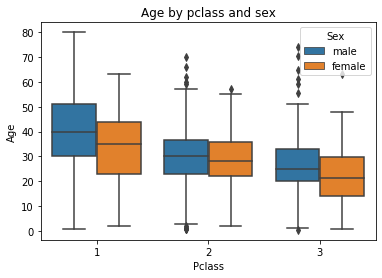

In [24]:
plt.figure()
sns.boxplot(data=train_data, x="Pclass", y="Age", hue="Sex")
plt.title('Age by pclass and sex')
plt.show()

The median age is lower for lower-class passengers. The median female age also appears to be less than the median male age. So both of these variables should be used for imputing age.

Are there any other important variables for imputing age?

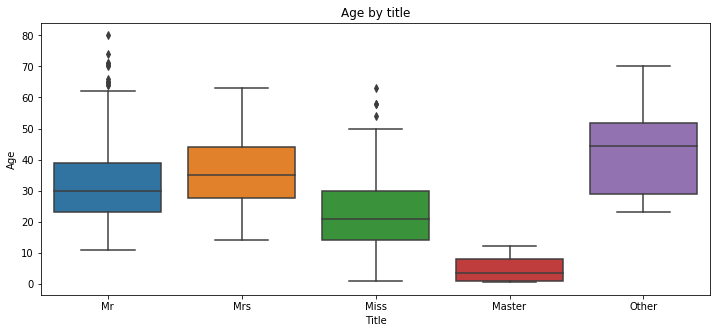

In [25]:
plt.figure(figsize = (12,5))
sns.boxplot(data=train_data, x="Title", y="Age")
plt.title('Age by title')
plt.show()

In [26]:
train_data.groupby('Title')['Age'].median()

Title
Master     3.5
Miss      21.0
Mr        30.0
Mrs       35.0
Other     44.5
Name: Age, dtype: float64

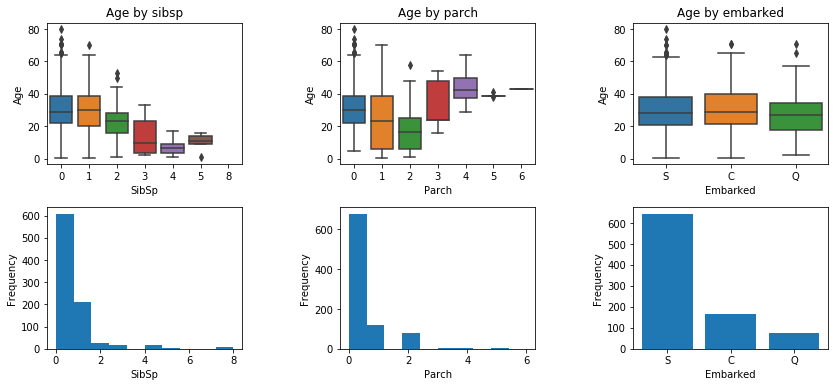

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,6))

ax = ax.ravel()

# Boxplots of age distribution, grouped by different variables
sns.boxplot(data=train_data, x="SibSp", y="Age", ax=ax[0])
ax[0].set_title('Age by sibsp')

sns.boxplot(data=train_data, x="Parch", y="Age", ax=ax[1])
ax[1].set_title('Age by parch')

sns.boxplot(data=train_data, x="Embarked", y="Age", ax=ax[2])
ax[2].set_title('Age by embarked')

# Histograms of distributions
ax[3].hist(data=train_data, x="SibSp")
ax[3].set_xlabel("SibSp")
ax[3].set_ylabel('Frequency')

ax[4].hist(data=train_data, x="Parch")
ax[4].set_xlabel("Parch")
ax[4].set_ylabel('Frequency')

ax[5].bar(train_data['Embarked'].value_counts().index, train_data['Embarked'].value_counts().values)
ax[5].set_xlabel('Embarked')
ax[5].set_ylabel('Frequency')

plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.3)

plt.show()

Generally, it looks like the passengers with more siblings aboard were younger. The data are too noisy to make any judgment about the relationship between number of parents/children aboard and age. There doesn't appear to be a relationship between port of embarkment and age.

However, from the histogram, it looks like the distribution of SibSp (and the other variables) is too uneven to use as a reliable predictor of age. So I'll just use sex and class to predict age.

In [28]:
# Use sex and pclass variables to predict age
X = train_data[['Female', 'Pclass1', 'Pclass2', 'Pclass3', 'Master', 'Mrs', 'Other']]
Y = train_data['Age']

# Separate data by presence of nan for age
nanind = np.isnan(train_data['Age'])
X_nan = X.loc[nanind]
Y_nan = Y.loc[nanind]
X_notnan = X.loc[~nanind]
Y_notnan = Y.loc[~nanind]

# Fit regression model
linreg = LinearRegression().fit(X_notnan, Y_notnan)

Let's look at the coefficients of the regression to see if they make sense

In [29]:
# Print intercept and coefficients
print(f'Intercept: {linreg.intercept_}')
for var,val in dict(zip(X.columns.tolist(), linreg.coef_.tolist())).items():
    print(f'{var}: {val}')

Intercept: 34.23525985875554
Female: -11.868564476627004
Pclass1: 6.679301094920684
Pclass2: -1.5168099575073952
Pclass3: -5.162491137413287
Master: -26.396838369013246
Mrs: 13.58196367865978
Other: 7.502552538948454


Looks reasonable. Women and lower-class passengers were generally younger, hence negative coefficients. The title Master refers to a child, hence negative coefficient. Mrs and "Other" titles were generally older, resulting in positive coefficients. Now I'll predict and impute the age of the missing data rows.


In [30]:
# Apply fitted model to predict age in samples with nan
age_pred = linreg.predict(X_nan)
train_data.loc[nanind,'Age'] = age_pred

# Verify that there are no nan in age column
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      891 non-null    int64   
 1   Survived         891 non-null    int64   
 2   Pclass           891 non-null    int64   
 3   Name             891 non-null    object  
 4   Sex              891 non-null    object  
 5   Age              891 non-null    float64 
 6   SibSp            891 non-null    int64   
 7   Parch            891 non-null    int64   
 8   Ticket           891 non-null    object  
 9   Fare             891 non-null    float64 
 10  Cabin            204 non-null    object  
 11  Embarked         889 non-null    object  
 12  AgeQuantile      714 non-null    category
 13  AgeGroup         714 non-null    category
 14  YoungBoy         891 non-null    int32   
 15  UpperClassWoman  891 non-null    int32   
 16  LowerClassMan    891 non-null    int32   
 1

And now I'll apply the same imputation for the test data

In [31]:
# Use sex and pclass variables to predict age
X = test_data[['Female', 'Pclass1', 'Pclass2', 'Pclass3', 'Master', 'Mrs', 'Other']]

# Find indices that need to be replaced
test_nanind = np.isnan(test_data['Age'])
X_nan = X.loc[test_nanind]

# Apply fitted model to samples with nan age
age_pred = linreg.predict(X_nan)

test_data.loc[test_nanind,'Age'] = age_pred

Let's see if the regression actually works well. I'll predict the ages for all the test data and plot the predicted ages against the known ages.

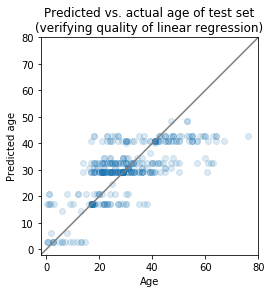

In [32]:
# Predict age of passengers in test dataset
age_pred = linreg.predict(X)

# Plot predicted age against actual age
plt.scatter(test_data['Age'], age_pred, alpha = 0.15)
# Plot identity line
plt.plot([-2, 80], [-2, 80], color = [0.5, 0.5, 0.5])

# Labels and appearance
plt.title('Predicted vs. actual age of test set\n(verifying quality of linear regression)')
plt.xlabel('Age')
plt.ylabel('Predicted age')
plt.axis('square')
plt.xlim((-2,80))
plt.ylim((-2,80))
plt.show()

Not spectacular, but better than nothing.

## Min-max scale continuous variables

In [33]:
# Fit scaler on training data, transform both training and testing data
scaler = MinMaxScaler()
train_data[['Age', 'Fare', 'SibSp', 'Parch']] = scaler.fit_transform(train_data[['Age', 'Fare', 'SibSp', 'Parch']])
test_data[['Age', 'Fare', 'SibSp', 'Parch']] = scaler.transform(test_data[['Age', 'Fare', 'SibSp', 'Parch']])

# Create model

Let's look at the correlation matrix again with the new variables (Pclass_1, Pclass_2, Pclass_3, Female, etc.)

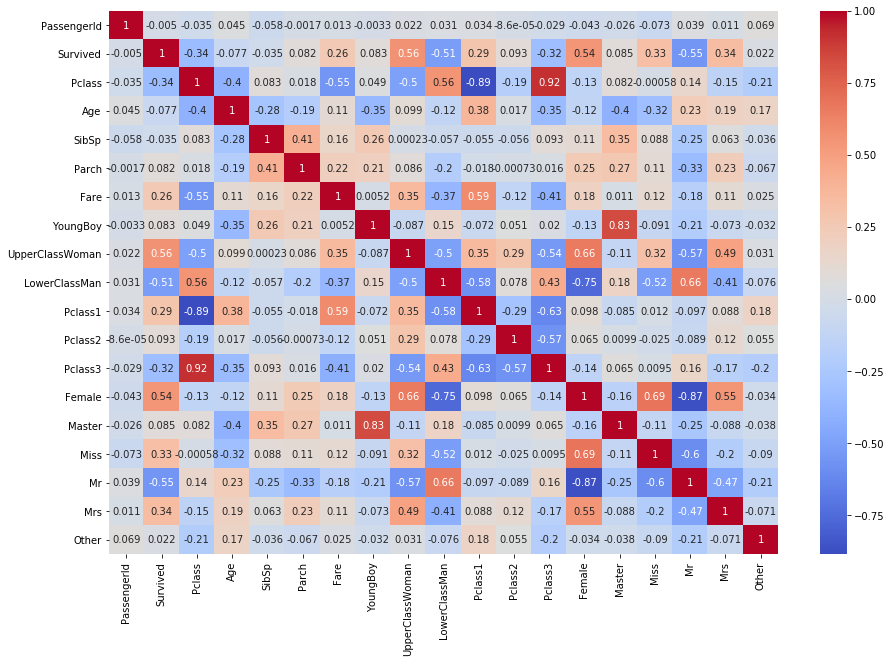

In [34]:
plt.figure(figsize=(15,10))
sns.heatmap(train_data.corr(), cmap='coolwarm', annot=True)
plt.show()

Features that look predictive of survival:
- UpperClassWoman
- LowerClassMan
- Female
- Master
- Age

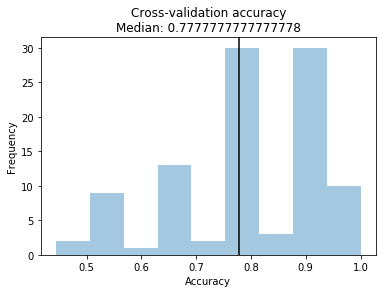

In [35]:
X = train_data[['Female', 'Master', 'Other', 'Age', 'UpperClassWoman', 'LowerClassMan']]
Y = train_data['Survived']

logreg_scores = cross_val_score(LogisticRegression(), X, Y, cv = 100)

med = np.median(logreg_scores)

sns.distplot(logreg_scores, kde=False)
plt.axvline(med, color='k')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Cross-validation accuracy\nMedian: {med}')

plt.show()

Looks decent (on average) -- time to make and save predictions!

In [36]:
# Fit logistic regression model
logreg = LogisticRegression().fit(train_data[['Female', 'Master', 'Other', 'Age', 'UpperClassWoman', 'LowerClassMan']], train_data['Survived'])

# Make predictions on test data
Y_predictions = logreg.predict(test_data[['Female', 'Master', 'Other', 'Age', 'UpperClassWoman', 'LowerClassMan']])

# Store predictions in dataframe
predictions = pd.DataFrame({'PassengerId': test_data['PassengerId'],
                            'Survived': Y_predictions
                           })

# Make sure everything looks okay
predictions.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [37]:
# Save predictions in csv
predictions.to_csv('predictions.csv', index = False)

# Open file to make sure it looks right
pd.read_csv('predictions.csv')

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


And so concludes my first Kaggle competition!